In [1]:
import sys

# Don't generate the __pycache__ folder locally
sys.dont_write_bytecode = True 

# Print exception without the buit-in python warning
sys.tracebacklimit = 0 

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import skimage as skimage

In [3]:
from tqdm.notebook import tqdm

In [4]:
from read_image import *
from make_binarization import *
from make_convolution import *
from make_image_gradients import *
from make_structure_tensor_2d import *
from make_coherence import *
from make_orientation import *
from make_vxvy import *

In [5]:
def split_into_chunks(img, chunk_size, overlap_pixels=0):
    """
    Splits a 2D grayscale image into chunks of a given size.
    
    Parameters:
        img (numpy.ndarray): The input 2D grayscale image.
        chunk_size (int): The size of the chunks to split 
        the image into.
        overlap_pixels (int): The overlap between chunks, 
        in pixels.
        
    Returns:
        list: A list of chunks, each of 
        size chunk_size x chunk_size.
        numpy.ndarray: The padded image, with 
        size padded_size x padded_size, where padded_size is a multiple of chunk_size.
    """    
    # Divide the image into chunks
    chunks = []
    for i in range(0, img.shape[0] - chunk_size + 1, chunk_size - overlap_pixels):
        for j in range(0, img.shape[1] - chunk_size + 1, chunk_size - overlap_pixels):
            chunk = img[i:i + chunk_size, j:j + chunk_size]
            chunks.append(chunk)
            
    return chunks

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def show_mosaic(chunks, cmap = 'viridis', overlap_pixels=0):
    """
    Shows a mosaic of the original image, constructed from its chunks, as n x n subplots with reduced borders.
    
    Parameters:
        img (numpy.ndarray): The input 2D grayscale image.
        chunks (list): A list of chunks, each of size chunk_size x chunk_size.
        overlap_pixels (int): The overlap between chunks, in pixels.
    """
    
    # Calculate the number of rows and columns
    n = int(np.ceil(np.sqrt(len(chunks))))
    
    fig, axs = plt.subplots(n, n, figsize=(5, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for i, chunk in enumerate(chunks):
        row = i // n
        col = i % n
        axs[row, col].imshow(chunk, cmap = cmap)
        axs[row, col].set_xticks([])
        axs[row, col].set_yticks([])

    plt.show()

In [7]:
def make_padded_image(img, chunk_size):
    # Pad the image to make it square and a multiple of chunk_size
    max_size = max(img.shape)
    padded_size = max_size + (chunk_size - max_size % chunk_size) % chunk_size
#     padded_img = np.full((padded_size, padded_size), np.nan)
    padded_img = np.zeros((padded_size, padded_size))
    padded_img[:img.shape[0], :img.shape[1]] = img

    return padded_img

In [8]:
def stitch_chunks(filtered_chunk_list, padded_img, img, chunk_size):
    # Calculate the number of chunks in each dimension
    num_chunks = padded_img.shape[0] // chunk_size

    # Initialize a new NumPy array for the reconstructed image
    reconstructed_img = np.full(padded_img.shape, np.nan)

    # Iterate over each chunk and copy it back to the correct location in the reconstructed image
    for i in range(len(filtered_chunk_list)):
        row = i // num_chunks
        col = i % num_chunks
        chunk = filtered_chunk_list[i]
        start_row = row * chunk_size
        end_row = start_row + chunk_size
        start_col = col * chunk_size
        end_col = start_col + chunk_size
        reconstructed_img[start_row:end_row, start_col:end_col] = chunk

    # Crop the reconstructed image to the size of the original input image
    reconstructed_img = reconstructed_img[:img.shape[0], :img.shape[1]]

    return reconstructed_img

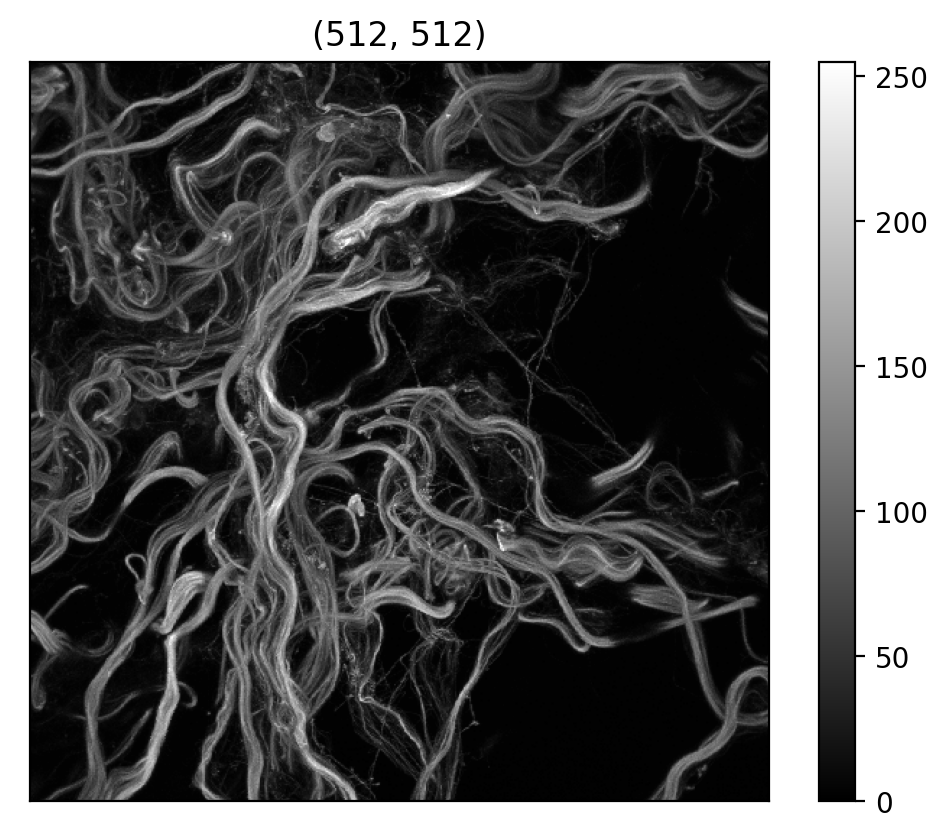

In [9]:
raw_image = convert_to_8bit_grayscale('TestImage1.tif')

plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(raw_image.shape)
plt.show()

In [10]:
each_chunk_size = 119

each_chunk_size = int(each_chunk_size)

In [11]:
padded_raw_image = make_padded_image(raw_image, each_chunk_size)

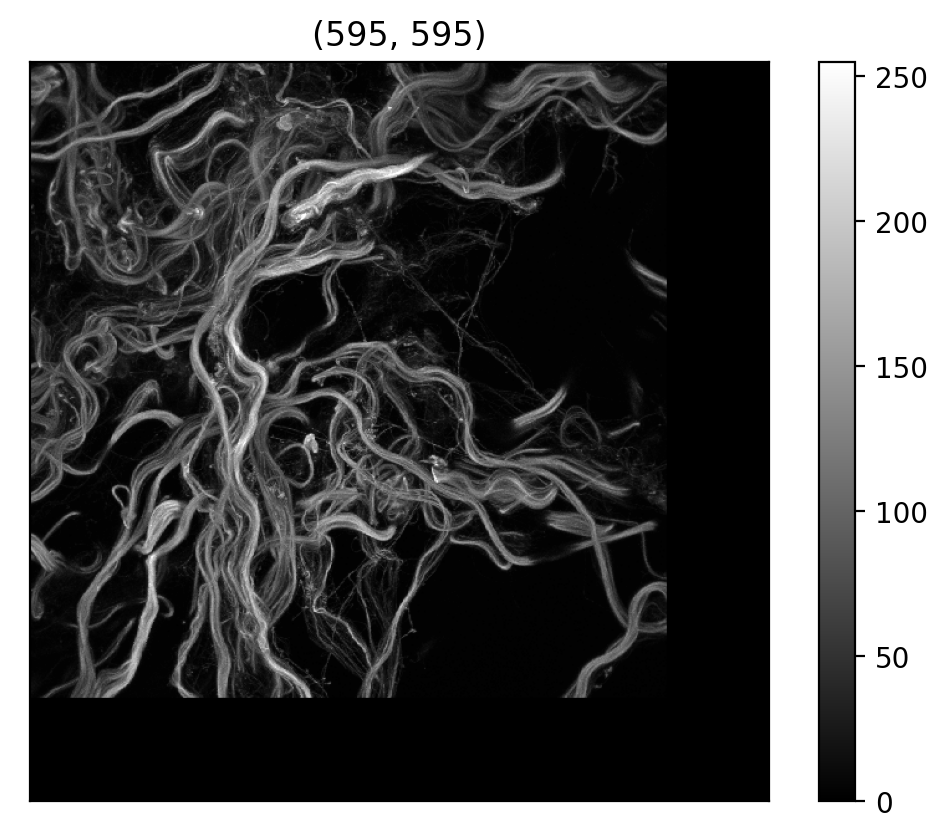

In [12]:
plt.imshow(padded_raw_image, cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(padded_raw_image.shape)
plt.show()

In [13]:
chunks = split_into_chunks(padded_raw_image, each_chunk_size)

len(chunks)

25

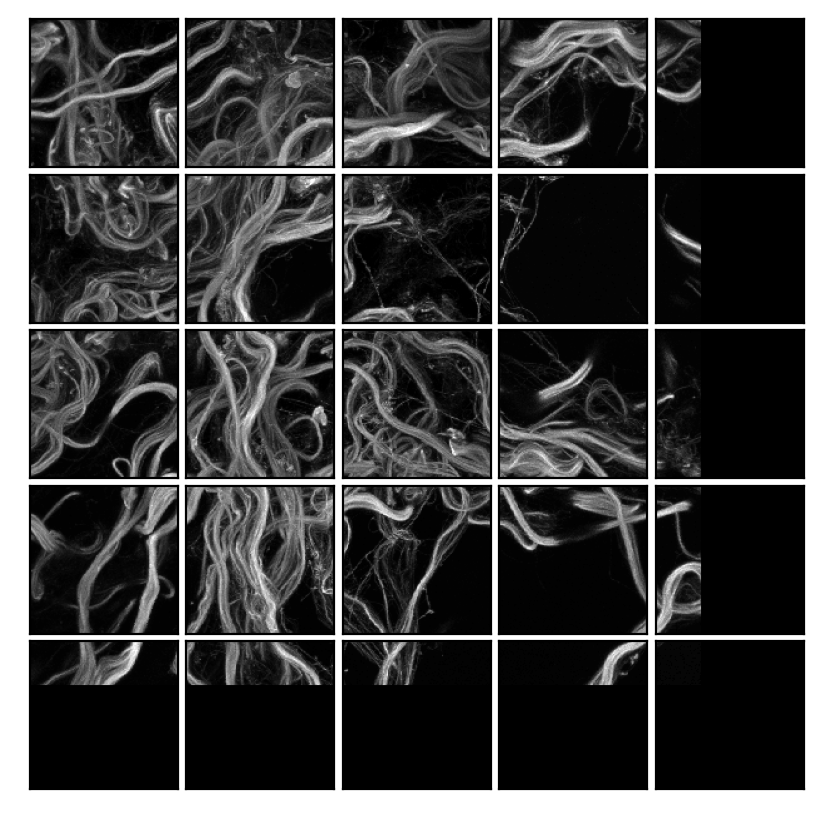

In [14]:
show_mosaic(chunks, cmap = 'gray')

In [15]:
# Local_Density_list = []
Image_Coherance_list = []
Image_Orientation_list = []

for i in tqdm(range(len(chunks))):
    
    ##################
    
    current_chunk = chunks[i]
    
    FilterKey = 1
    filtered_chunk = skimage.filters.gaussian(current_chunk, 
                                              sigma = FilterKey, 
                                              mode = 'nearest', 
                                              preserve_range = True)
    
    binarized_chunk = binarize_image(filtered_chunk)
    
#     # Define the kernel and it's size
#     LocalDensityKey = 10
#     local_kernel_size = LocalDensityKey
#     if (local_kernel_size % 2 == 0):
#         local_kernel_size = local_kernel_size + 1
#     if (local_kernel_size < 3):
#         local_kernel_size = 3

#     local_kernel = np.ones((local_kernel_size, local_kernel_size), dtype = np.float32) / (local_kernel_size * local_kernel_size)

#     Local_Density = convolve(binarized_chunk, local_kernel)
    
#     # Normalize Local_Density between 0 and 1
#     if (Local_Density.max() > 0):
#         Local_Density = Local_Density / Local_Density.max()
#     else:
#         raise Exception('Local_Density might be an empty image in this chunk')

    # Calculate image gradients in X and Y directions
    image_gradient_x, image_gradient_y = make_image_gradients(filtered_chunk)
    
    # Calculate the structure tensor and solve for EigenValues, EigenVectors
    LocalSigmaKey = 4
    Structure_Tensor, EigenValues, EigenVectors, Jxx, Jxy, Jyy = make_structure_tensor_2d(image_gradient_x, image_gradient_y, LocalSigmaKey)
    
    ThresholdValueKey = 20
    
    Image_Coherance = make_coherence(filtered_chunk, EigenValues, Structure_Tensor, ThresholdValueKey)
    
    Image_Orientation = make_orientation(filtered_chunk, Jxx, Jxy, Jyy, ThresholdValueKey)
    vx, vy = make_vxvy(filtered_chunk, EigenVectors, ThresholdValueKey)
    
    ##################
    
#     Local_Density_list.append(Local_Density)
    Image_Coherance_list.append(Image_Coherance)
    Image_Orientation_list.append(Image_Orientation)
    
#     local_density = np.where(local_density == 0, np.nan, local_density)

  0%|          | 0/25 [00:00<?, ?it/s]

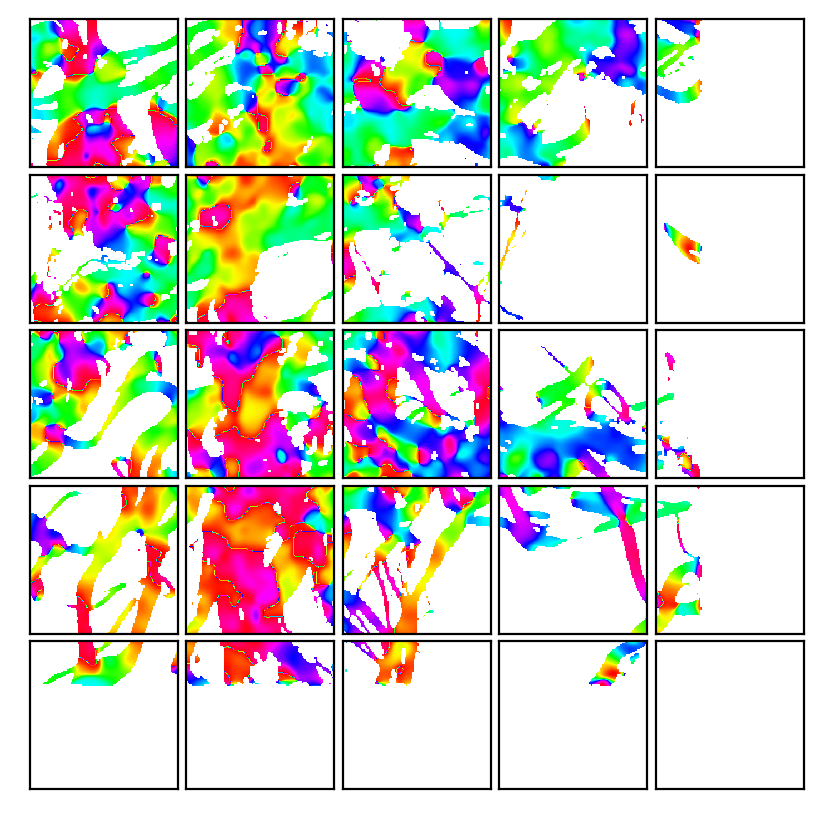

In [16]:
show_mosaic(Image_Orientation_list, cmap = 'hsv')

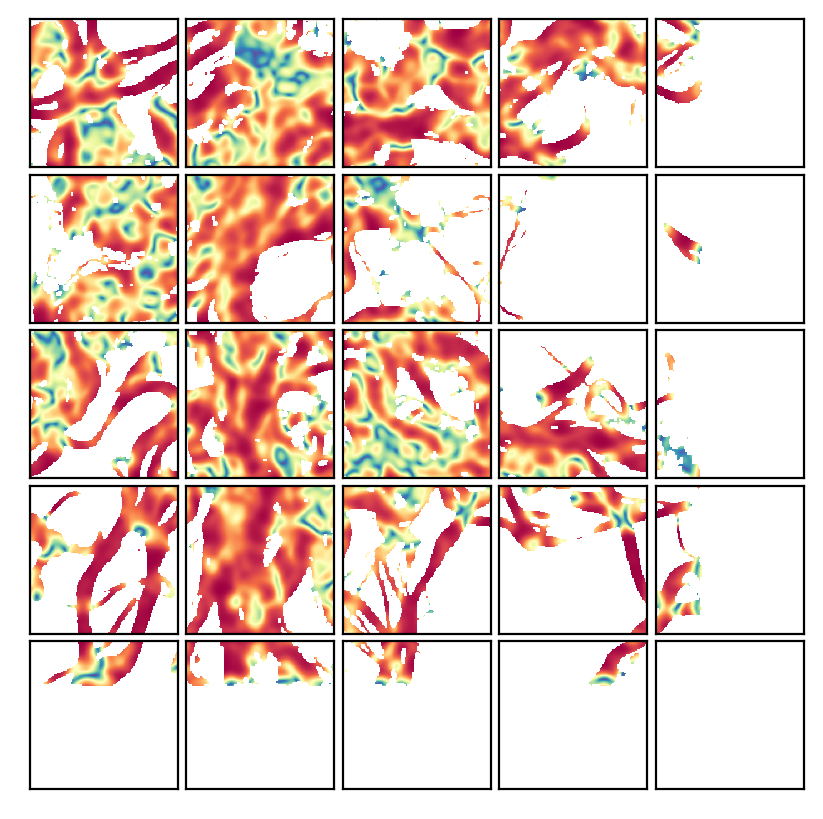

In [17]:
show_mosaic(Image_Coherance_list, cmap = 'Spectral_r')

In [18]:
Image_Orientation = stitch_chunks(Image_Orientation_list, 
                                  padded_raw_image, raw_image, 
                                  each_chunk_size)

Image_Coherance = stitch_chunks(Image_Coherance_list, 
                                padded_raw_image, raw_image, 
                                each_chunk_size)

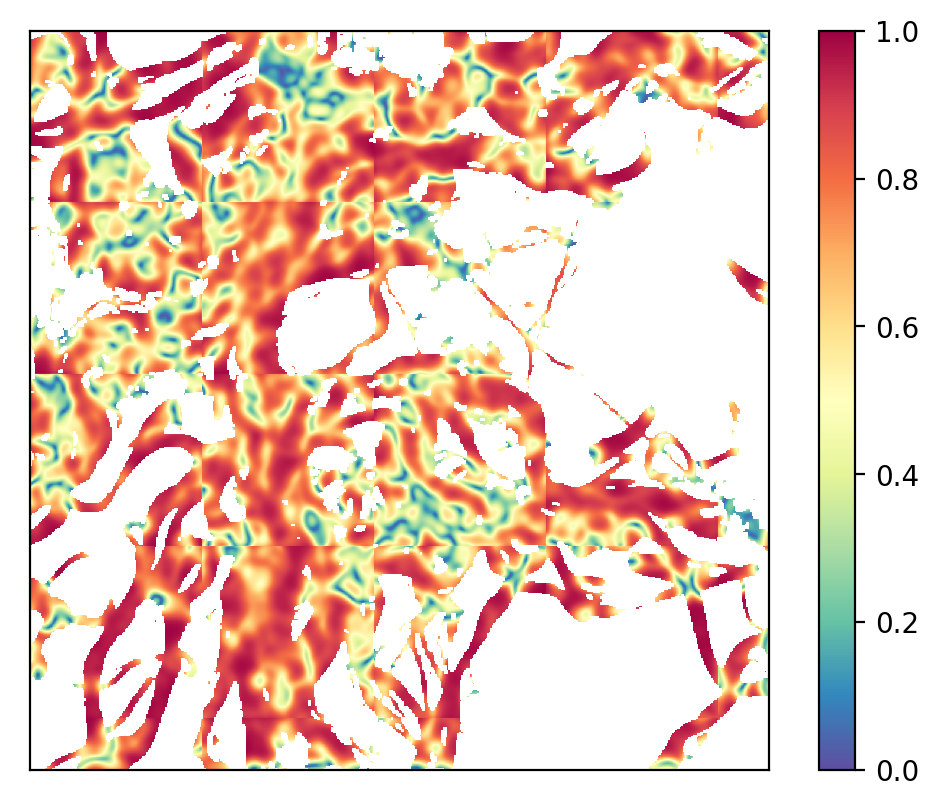

In [19]:
plt.imshow(Image_Coherance, cmap='Spectral_r', 
           vmin = 0, vmax = 1)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

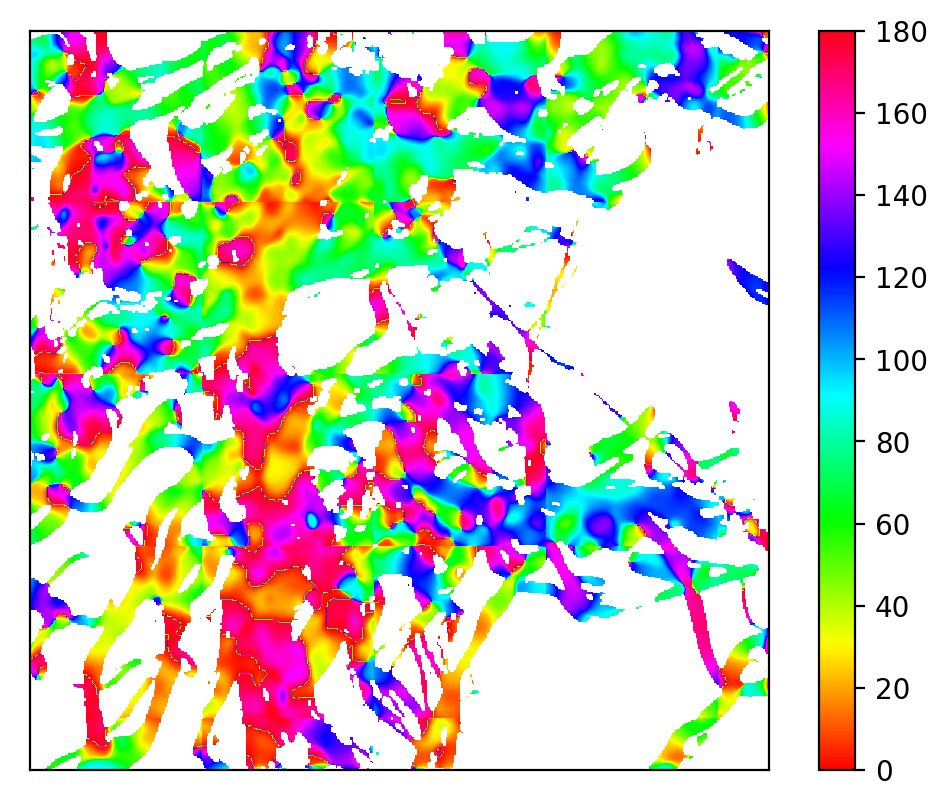

In [20]:
plt.imshow(Image_Orientation, cmap='hsv', vmin = 0, vmax = 180)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()